# No-Snow Transition Plot
We combine into a single plot to increase clarity

In [9]:
# basic imports for geospatial analysis
import sys
import seaborn as sns
import pandas as pd
sys.path.append("../notebooks")
from imports import *
mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
lat_new = np.arange(32, 52, 0.5)
lon_new = np.arange(235, 255, 0.5)

mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)
# for grid plotting
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import bottleneck as bn
def rollavg_bottlneck(a,n):
    return bn.move_mean(a, window=n,min_count = None)

In [10]:
# File Paths
snow_historical   = glob("/decp/SPEAR_MED/SPEAR_c192_o1_Hist_AllForc_IC1921_K50/"
                         "pp_ens_*/land/ts/monthly/94yr/land.192101-201412.snow.nc")
snow_future   = glob("/decp/SPEAR_MED/SPEAR_c192_o1_Scen_SSP585_IC2011_K50/"
                     "pp_ens_*/land/ts/monthly/86yr/land.201501-210012.snow.nc")
snow_future245   = glob("/decp/SPEAR_MED/SPEAR_c192_o1_Scen_SSP245_IC2011_K50/"
                     "pp_ens_*/land/ts/monthly/86yr/land.201501-210012.snow.nc")

In [11]:
# load shapefile data from geopandas
gpd_HUC2 = gpd.read_file("/nbhome/Julian.Schmitt/shape/huc2_regions.shp")
gpd_HUC4 = gpd.read_file("/nbhome/Julian.Schmitt/shape/huc4_regions.shp")

# load regions into Polygon objects
HUC2 = [poly.buffer(0) for poly in gpd_HUC2['geometry']]
HUC4 = [poly.buffer(0) for poly in gpd_HUC4['geometry']]

# create HUC2 mask and add to dataset
HUC2_names, HUC2_abbrev = gpd_HUC2['Name'], gpd_HUC2['HUC2']
RM2 = regionmask.Regions(HUC2, names = HUC2_names.values, abbrevs=HUC2_abbrev.values)

# create HUC4 mask
HUC4_names, HUC4_abbrev = gpd_HUC4['Name'], gpd_HUC4['HUC4']
RM4 = regionmask.Regions(HUC4, names = HUC4_names.values, abbrevs=HUC4_abbrev.values)

HUC2_drought = RM2.mask(lon_new, lat_new) # create mask over dataset lat-lon
HUC4_drought = RM4.mask(lon_new, lat_new) # create mask over dataset lat-lon

KeyboardInterrupt: 

In [12]:
ens_files_585 = glob("/work/Julian.Schmitt/data/SWE_P/future_585/*.nc")
ens_files_245 = glob("/work/Julian.Schmitt/data/SWE_P/future_245/*.nc")

def get_snow_sum(array, snow_thresh):
    # different scenarios
    frac_lo = np.zeros(len(array))
    # iterate through years
    for index in range(len(array)):
        # fraction of max swe for historically snowy cells 
        ar = np.array(array[index]).reshape(1,-1)[0][(np.array(mask_ds.snow).reshape(1,-1) >20)[0]]
        frac_lo[index] = sum(ar < snow_thresh)

    return frac_lo

def transition(file, snow_thresh, alpha):
    """snow threshold is what we consider low snow. 
        alpha is transition percentage cutoff"""
    # read file and aggregate
    ds = xr.open_dataset(file)
    # aggregate to area
    area_frac_low_snow = get_snow_sum(ds.snow, snow_thresh)
    # rolling average for area percentage
    num_gridcells = int(np.sum(mask_ds.snow >20))
    roll_avg = rollavg_bottlneck(area_frac_low_snow/num_gridcells, 10)
    
    # get last year where rolling average is below threshold alpha
    transition_year = 2100-np.argmax(np.flip(roll_avg) < alpha)+1
    if transition_year ==2101:
        return np.nan
    else:
        return transition_year
def trans_ar(snow_thresh, alpha):
    ncores = os.cpu_count()
    trans = Parallel(n_jobs=ncores)(delayed(transition)(ens_files[i], snow_thresh, alpha) for i in range(30))
    return trans
def mask_ensemble(hist, mask):
    """Groups data by region"""
    ds_HUC2 = hist.copy()
    ds_HUC2['mask'] = mask
    
    ds_HUC2 = ds_HUC2.groupby('mask').mean()
    ds_HUC2 = ds_HUC2.assign_coords(regions=("mask", RM2.names[13:18]))
    return ds_HUC2

In [13]:
def prop_transition(file, region, snow_thresh, alpha):
    """Calculate Proportion at threshold for specific region"""
    # open file and add mask
    H2 = xr.open_dataset(file)
    H2['mask']= HUC2_drought
    
    # calculate prop under historical snow_thresh(old) in snowy area of that region
    time_ar = np.zeros(len(H2.time))
    for time in range(len(H2.time)):
        ar = np.array(H2.where(H2.mask==region).snow[time])[mask_ds.snow >20] # select snowy part of region
        ar_snowy = ar[~np.isnan(ar)] # get values just in historically snowy region
        time_ar[time] = sum(ar_snowy <snow_thresh) / len(ar_snowy) # proportion that are not snowy 
    
    # 10 year rolling average
    ar_roll = rollavg_bottlneck(time_ar, 10)
    
    # get last year where rolling average is below threshold alpha
    transition_year = 2100-np.argmax(np.flip(ar_roll) < alpha)+1
    if transition_year ==2101:
        return np.nan, ar_roll
    else:
        return transition_year, ar_roll
def wrapper(ens_file_no, snow_thresh, alpha, file_list):
    return [prop_transition(file_list[i], ens_file_no, snow_thresh, alpha)[0] for i in range(30)]
def s(ar):
    """Calculate percentage of ensemble members that loose snow before 2100"""
    return round(sum(~np.isnan(np.array(ar)))/len(ar)*100)

In [ ]:
%%time
# Compute distribution of onset for all Snowy HUC2s 
ncores = os.cpu_count()
snow_thresh = 0.10
dates_585 = np.array([])
dates_245 = np.array([])
for alpha in [0.5, 0.75, 0.9]:
    dates_585 = np.append(dates_585, Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, alpha, ens_files_585) for i in range(13,18)))
    dates_245 = np.append(dates_245, Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, alpha, ens_files_245) for i in range(13,18)))

In [14]:
ncores = os.cpu_count()
snow_thresh = 0.10
dates_585_50 = Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, 0.5, ens_files_585) for i in range(13,18))
dates_585_75 = Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, 0.75, ens_files_585) for i in range(13,18))
dates_585_90 = Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, 0.9, ens_files_585) for i in range(13,18))

dates_245_50 = Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, 0.5, ens_files_245) for i in range(13,18))
dates_245_75 = Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, 0.75, ens_files_245) for i in range(13,18))
dates_245_90 = Parallel(n_jobs=ncores)(delayed(wrapper)(i, snow_thresh, 0.9, ens_files_245) for i in range(13,18))

In [59]:
df = pd.DataFrame(columns=["Year", "Scenario", "Region", "Threshold"])

A = [50, 75, 90]
m585s = [dates_585_50, dates_585_75, dates_585_90]
m245s = [dates_245_50, dates_245_75, dates_245_90]
for i in range(3):
    thresh = A[i]
    m585 = m585s[i]
    m245 = m245s[i]
    for region in range(5):
        for ens in range(30):
            df = df.append({"Year" : m585[region][ens],
                            "Scenario":"SSP5-8.5", 
                            "Region" : basic_ticks[region],
                            "Threshold" : A[i]}, ignore_index=True)
            df = df.append({"Year" : m245[region][ens], 
                            "Scenario" : "SSP2-4.5",
                            "Region" : basic_ticks[region],
                            "Threshold": A[i]}, ignore_index=True)
df = df.astype({"Year": float, "Scenario": str, "Region": str, "Threshold": int})
            
    

In [11]:
# generate ticks
basic_ticks = ['Upper Colorado', 'Lower Colorado', 'Great Basin', 'Pacific Northwest', 'California']

In [32]:
df.loc[df['Threshold'] == 50]

,Year,Scenario,Region,Threshold
0,2063.0,585,Upper Colorado,50
1,2064.0,245,Upper Colorado,50
2,2064.0,585,Upper Colorado,50
3,2099.0,245,Upper Colorado,50
4,2062.0,585,Upper Colorado,50
...,...,...,...,...
295,2035.0,245,California,50
296,2012.0,585,California,50
297,2012.0,245,California,50
298,2035.0,585,California,50


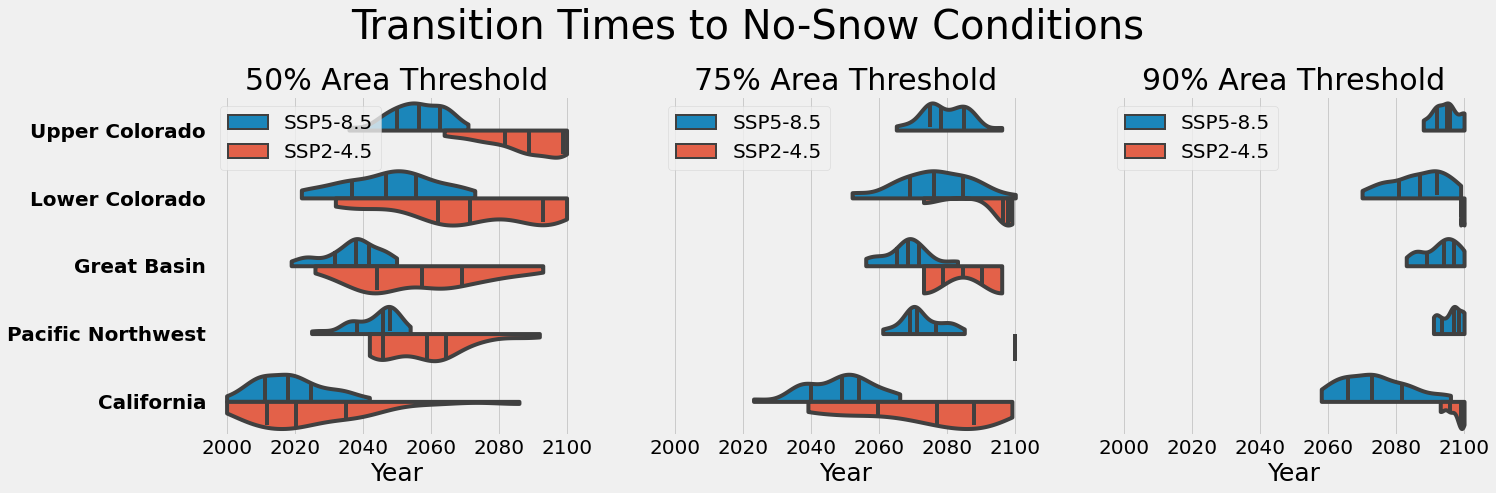

In [71]:
plt.style.use("fivethirtyeight")
# plot
fig, ax = plt.subplots(1,3, figsize=(21,7), sharey = True, sharex = True)
fig.suptitle(f"Transition Times to No-Snow Conditions", fontsize=40)


sns.violinplot(ax = ax[0], data=df.loc[df['Threshold'] == 50], y="Region", x="Year", hue="Scenario", split=True, cut=0,bw=0.4, inner="quartile", scale="width")
ax[0].set_title(f"50% Area Threshold", fontsize=30)
ax[0].set_xlabel("Year", fontsize = 25)
ax[0].set_yticklabels(basic_ticks, size = 20, weight = 'bold')
ax[0].set_ylabel("")
ax[0].tick_params(axis = 'x', labelsize=20)
ax[0].legend(prop = {'size' : 20})
#ax[0].get_legend().remove()



sns.violinplot(ax = ax[1], data=df.loc[df['Threshold'] == 75], y="Region", x="Year", hue="Scenario", split=True, cut=0,bw=0.4, inner="quartile", scale="width")
ax[1].set_title(f"75% Area Threshold", fontsize=30)
ax[1].set_xlabel("Year", fontsize = 25)
ax[1].set_ylabel("")
ax[1].tick_params(axis = 'x', labelsize=20)
ax[1].legend( prop = {'size' : 20})




sns.violinplot(ax = ax[2], data=df.loc[df['Threshold'] == 90], y="Region", x="Year", hue="Scenario", split=True, cut=0,bw=0.4, inner="quartile", scale="width")
ax[2].set_title(f"90% Area Threshold", fontsize=30)
ax[2].set_xlabel("Year", fontsize = 25)
ax[2].set_ylabel("")
ax[2].tick_params(axis = 'x', labelsize=20)
ax[2].legend( prop = {'size' : 20})


fig.tight_layout()
plt.subplots_adjust(wspace = 0.2)
plt.savefig("/home/Julian.Schmitt/plots/transition_times.png", dpi =175)

In [85]:
df[df['Threshold'] == 50].groupby(["Region", "Scenario"]).max()

Year  Threshold
Region            Scenario                   
California        SSP2-4.5  2086.0         50
                  SSP5-8.5  2042.0         50
Great Basin       SSP2-4.5  2093.0         50
                  SSP5-8.5  2050.0         50
Lower Colorado    SSP2-4.5  2100.0         50
                  SSP5-8.5  2073.0         50
Pacific Northwest SSP2-4.5  2092.0         50
                  SSP5-8.5  2054.0         50
Upper Colorado    SSP2-4.5  2100.0         50
                  SSP5-8.5  2071.0         50